<a href="https://colab.research.google.com/github/epigos/learning-pytorch/blob/master/02-MLP-Image-Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import time
import copy
import warnings
from collections import defaultdict, deque
warnings.filterwarnings('ignore')

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets
from PIL import Image, ImageFile
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available(): print('Device name:', torch.cuda.get_device_name())

Device name: Tesla K80


# Load MNIST data

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5, ))
])

# load train and validation set
dataset = datasets.MNIST('./data', download=True, train=True, transform=transform)
train_set, val_set = data.random_split(dataset, [50000, 10000])  # split into train and val set

train_loader = data.DataLoader(train_set, batch_size=128, shuffle=True)
val_loader = data.DataLoader(val_set, batch_size=128, shuffle=True)
# load test set
test_set = datasets.MNIST('./data', download=True, train=False, transform=transform)
test_loader = data.DataLoader(test_set, batch_size=128, shuffle=True)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


In [4]:
print(f"Number of training images: {len(train_set)}")
print(f"Number of validation images: {len(val_set)}")
print(f"Number of testing images: {len(test_set)}")
print(f"Size of each image: {train_set[0][0].size()}")
data_loader = {'train': train_loader, 'val': val_loader}

Number of training images: 50000
Number of validation images: 10000
Number of testing images: 10000



Size of each image: torch.Size([1, 28, 28])


## Show some images

In [0]:
def imshow(tensor, ax=None):
    np_img = tensor.permute(1, 2, 0).numpy()
    if not ax:
        _, ax = plt.subplots()
    ax.imshow(np_img.astype(np.uint8), cmap='Greys')
    plt.axis('off')

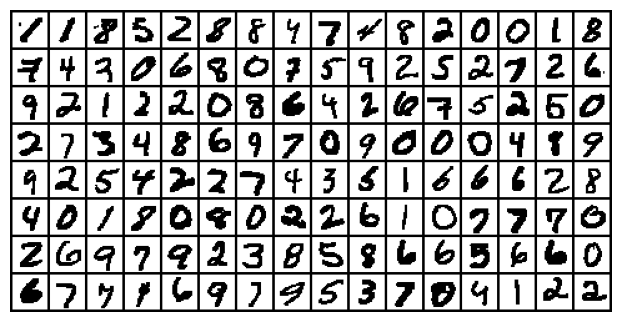

In [6]:
# get some random training images
data_iter = iter(data_loader['train'])
sample_images, labels = data_iter.next()
# show images
fig, ax = plt.subplots(figsize=(12, 4), dpi=100)
grid = torchvision.utils.make_grid(sample_images, nrow=16)
imshow(grid, ax=ax)

In [7]:
# classes
categories = dataset.class_to_idx
output_size = len(categories)
categories

{'0 - zero': 0,
 '1 - one': 1,
 '2 - two': 2,
 '3 - three': 3,
 '4 - four': 4,
 '5 - five': 5,
 '6 - six': 6,
 '7 - seven': 7,
 '8 - eight': 8,
 '9 - nine': 9}

# Create the MLP model

In [0]:
class MLP(nn.Module):

    def __init__(self, input_size=28, output_size=output_size):
        super().__init__()
        self.input_size = input_size
        self.fc1 = nn.Linear(self.input_size * self.input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_size)
    
    def forward(self, x):
        x = x.view(-1, self.input_size * self.input_size)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = MLP()

In [9]:
net

MLP(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

In [10]:
# test network
net(torch.rand(1, 1, 28, 28))

tensor([[ 0.1251, -0.0040,  0.0306, -0.1587,  0.0360,  0.0089,  0.0131,  0.0534,
         -0.0101, -0.0435]], grad_fn=<AddmmBackward>)

# Train the network

In [0]:
def train(model, data_loader, epochs=5, lr=1e-2):
    model.__init__()  # reset model weights
    model = model.to(device)
    # define training function
    optimizer = optim.Adam(model.parameters(), lr=lr)
    # define loss function
    criterion = nn.CrossEntropyLoss()
    # define training variables
    since = time.time()
    best_weights = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    loss_history = defaultdict(lambda: deque(maxlen=epochs))
    accuracy_history = defaultdict(lambda: deque(maxlen=epochs))

    for epoch in range(1, epochs+1):
        print('Epoch {}/{}'.format(epoch, epochs))
        print('-' * 60)    

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            total = 0

            # Iterate over data.
            for inputs, labels in data_loader[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # make predictions
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs.data, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                total += labels.size(0)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels).item()

            epoch_loss = running_loss / total
            epoch_acc = running_corrects / total

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            loss_history[phase].append(epoch_loss)
            accuracy_history[phase].append(epoch_acc)
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_weights = copy.deepcopy(model.state_dict())
            

    time_elapsed = time.time() - since
    print('-' * 60)
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.3f} %'.format(100 * best_acc))
    print('=' * 60, '\n')
    # load best weights
    model.load_state_dict(best_weights)
    return loss_history, accuracy_history

In [12]:
loss_history, accuracy_history = train(net, data_loader, epochs=10)

Epoch 1/10
------------------------------------------------------------
train Loss: 0.4529 Acc: 0.8564
val Loss: 0.2524 Acc: 0.9217
Epoch 2/10
------------------------------------------------------------
train Loss: 0.2229 Acc: 0.9340
val Loss: 0.1920 Acc: 0.9434
Epoch 3/10
------------------------------------------------------------
train Loss: 0.1907 Acc: 0.9434
val Loss: 0.2273 Acc: 0.9337
Epoch 4/10
------------------------------------------------------------
train Loss: 0.1726 Acc: 0.9484
val Loss: 0.1989 Acc: 0.9421
Epoch 5/10
------------------------------------------------------------
train Loss: 0.1707 Acc: 0.9485
val Loss: 0.1914 Acc: 0.9431
Epoch 6/10
------------------------------------------------------------
train Loss: 0.1527 Acc: 0.9546
val Loss: 0.2074 Acc: 0.9355
Epoch 7/10
------------------------------------------------------------
train Loss: 0.1574 Acc: 0.9523
val Loss: 0.1970 Acc: 0.9408
Epoch 8/10
------------------------------------------------------------
trai

# Visualize training performance

In [0]:
def plot_learning_curve(loss_history, accuracy_history, figsize=(12, 4)):

    x_values = range(1, len(loss_history['train'])+1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize, sharex=True)
    lines = dict(train='--', val='-')

    for phase, label in zip(['train', 'val'], ['Training', 'Validation']):
        ax1.plot(x_values, loss_history[phase], lines[phase],  label=f"{label}")

    plt.sca(ax1)
    plt.xlabel('Epoch')
    plt.legend()
    _ = plt.title("Loss")

    for phase, label in zip(['train', 'val'], ['Training', 'Validation']):
        ax2.plot(x_values, accuracy_history[phase], lines[phase], label=f"{label}")

    plt.sca(ax2)
    plt.xlabel('Epoch')
    plt.legend()
    _ = plt.title("Accuracy")
    _ = plt.suptitle(f"Training Performance\n")
    _ = plt.subplots_adjust(top=0.9)
    plt.show()

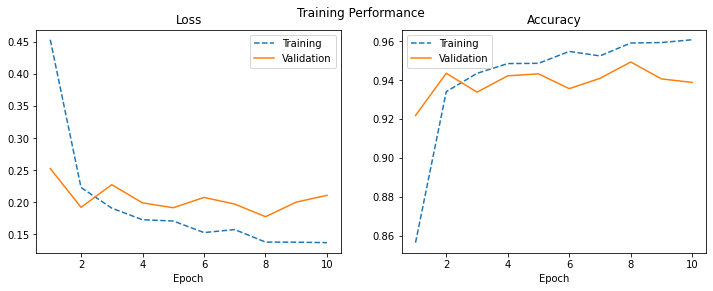

In [14]:
plot_learning_curve(loss_history, accuracy_history)

# Evaluate model

In [15]:
# convert dataset ids to classes
idx_to_class = {v:k for k,v in categories.items()}
idx_to_class

{0: '0 - zero',
 1: '1 - one',
 2: '2 - two',
 3: '3 - three',
 4: '4 - four',
 5: '5 - five',
 6: '6 - six',
 7: '7 - seven',
 8: '8 - eight',
 9: '9 - nine'}

In [0]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report


def plot_confusion_matrix(y_true, y_pred, labels, normalize=None, 
                          title='Confusion matrix', cmap=plt.cm.Blues, ax=None):
    """
    Function to plot confusion matrix.
    Adapted from: https://github.com/scikit-learn/scikit-learn/blob/95d4f0841/sklearn/metrics/_plot/confusion_matrix.py#L119
    """
    cm = confusion_matrix(y_true, y_pred, labels=labels, normalize=normalize)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=labels)
    disp = disp.plot(cmap=cmap, ax=ax)
    _ = disp.ax_.set_title(title)
    disp.ax_.grid(False)
    return disp.ax_


def predict(model, test_loader):
    """Function to predict test data"""
    correct, total = 0, 0
    targets = []
    predictions = []

    with torch.no_grad():
        model.eval()
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model.forward(images)
            _, predicted = torch.max(outputs.data, 1)
        
            total += labels.size(0)
            correct += (predicted ==labels).sum().item()
            # append labels
            targets.extend(labels.cpu().detach().numpy())
            predictions.extend(predicted.cpu().detach().numpy())

    score = correct / total
    targets = [idx_to_class[i] for i in targets]
    predictions = [idx_to_class[i] for i in predictions]
    return score, targets, predictions

In [17]:
# make test predictions
%%time
score, y_true, y_pred = predict(net, test_loader)

CPU times: user 2.14 s, sys: 8.96 ms, total: 2.14 s
Wall time: 2.14 s


In [18]:
print("Test score: {:.2f} %".format(100 * score))

Test score: 95.06 %


In [19]:
print("Classification report: \n\n{}\n".format(
    classification_report(y_true, y_pred)
))

Classification report: 

              precision    recall  f1-score   support

    0 - zero       0.95      0.99      0.97       980
     1 - one       0.97      0.99      0.98      1135
     2 - two       0.95      0.94      0.94      1032
   3 - three       0.92      0.95      0.94      1010
    4 - four       0.97      0.95      0.96       982
    5 - five       0.91      0.96      0.94       892
     6 - six       0.96      0.96      0.96       958
   7 - seven       0.95      0.96      0.95      1028
   8 - eight       0.97      0.91      0.94       974
    9 - nine       0.96      0.90      0.93      1009

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000




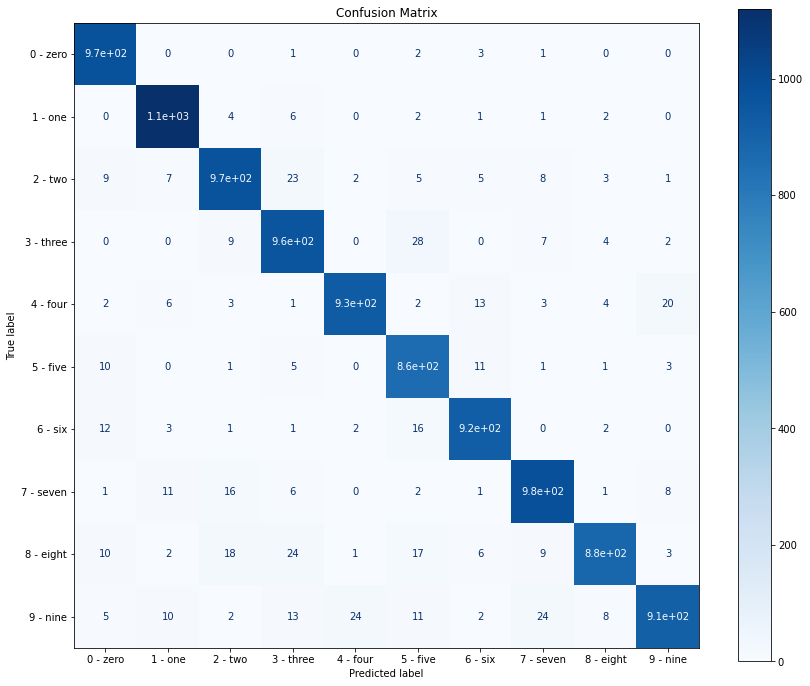

In [20]:
labels = list(idx_to_class.values())
# plot confusion matrix
fig, ax = plt.subplots(figsize=(14, 12))
_ = plot_confusion_matrix(y_true, y_pred, labels, ax=ax, title=f"Confusion Matrix")

In [0]:
# save model
torch.save({
    'state_dict': net.state_dict(),
    'idx_to_class': idx_to_class,
}, './mlp_mnist.pth')

In [22]:
!ls -lh mlp_mnist.pth

-rw-r--r-- 1 root root 429K Jun  7 13:01 mlp_mnist.pth
